### Analysis 
This notebook evaluates RQ1 and RQ2 using topics created with the parameters: 
* KM clusters = 20
* Dimensions = 768 (no PCA)

#### Imports & Adding in Document Lengths

In [85]:
import pandas as pd
from ast import literal_eval
import operator
import numpy as np
import statsmodels as sm
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.special import rel_entr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


%matplotlib inline

In [86]:
# Reading in data 
df = pd.read_csv("../distribution.csv")
tweets = pd.read_csv("../data/hydrated_tweets.csv")

# Adding in length 
df['tweetLengthWords'] = df['tweetTextList'].apply(lambda x: len(literal_eval(x)))
df['noteLengthWords'] = df['noteTextList'].apply(lambda x: len(literal_eval(x)))

# This will be used to determine a length cutoff for tweets
df[['tweetLengthWords', 'noteLengthWords']].describe()

,tweetLengthWords,noteLengthWords
count,11599.000000,11599.000000
mean,14.474006,14.656436
std,7.722712,7.712288
min,1.000000,1.000000
25%,8.000000,8.000000
50%,14.000000,15.000000
75%,21.000000,22.000000
max,44.000000,45.000000


#### Mapping note ratings to document pairs

In [87]:
# Parsing the ratings data 

ratings = pd.read_csv("../data/ratings-00000.tsv", sep = "\t")

ratings["helpfulnessLevel"] = np.where(ratings["helpfulnessLevel"].isna(),
                                       ratings['helpful'],
                                      ratings["helpfulnessLevel"])

ratings["helpfulnessLevel_proxy"] = np.where(ratings["helpfulnessLevel"] == "HELPFUL", 1,
                                      np.where(
                                      ratings["helpfulnessLevel"] == "NOT_HELPFUL", -1, 
                                      np.where(
                                      ratings["helpfulnessLevel"] == "SOMEWHAT_HELPFUL", 0,
                                      ratings["helpfulnessLevel"]))
                                      )

ratings["helpfulnessLevel_proxy"] = ratings["helpfulnessLevel_proxy"].astype(float)

# could try to this with mode or median for whateve reason 
ratings_grouped = ratings.groupby(["noteId"])['helpfulnessLevel_proxy'].mean().reset_index()

ratings_grouped = ratings.groupby(["noteId"]).agg({"helpfulnessLevel_proxy":"mean",
                                                 "helpfulUniqueContext": "sum",
                                                 "helpfulImportantContext": "sum",
                                                 "notHelpfulOffTopic": "sum"})

In [88]:
merged_df = pd.merge(df, ratings_grouped, how="left", on="noteId", indicator="merge_ratings")

# creating the final test set for analysis
# note/tweet pairs that have ratings associated with the notes 

test = merged_df[merged_df['merge_ratings'] == "both"]


#### Sample note/tweets with varying lengths 

In [89]:
# a tweet with commentary about BLM and MLK, a note refuting the tweet's take. High quality
mlk = df[df['noteId'] == 1483230774144888832]

# a tweet about President Biden & Afghanistan, a note about the situation in Afghanistan. Unknown quality  
afghanistan = df[df['noteId'] == 1432821040392986634]

# a tweet asking Santa for weapons, a response that Santa isn't real. Low quality / meme-y. Short 
santa = df[df['noteId'] == 1467558037116178436]

#### RQ 1

In [90]:
def probPlot(sliced_df, title):
    """
    Apply function for a dataframe. Use in a lambda function 
    Input: Distribution dataframe, title for plot 
    Output: Barplot of a document's probability distribution
    """
    temp = literal_eval(sliced_df['probs_note'].values[0])
    temp2 = literal_eval(sliced_df['probs_tweet'].values[0])
    classes = list(temp.keys())
    classes = [str(x+1) for x in classes]
    p = list(temp.values())
    q = list(temp2.values())
    # maintain good social media ethics practices and don't call out specific birdwatch notes / tweets here 
    return classes, p, q
    
def KL(x, order = "tn"):
    """
    Apply function for a dataframe. Use in a lambda function 
    Input: Distribution dataframe, order keyword for KL direction. nt = KL(N || T), 
           tn = KL(T || N)
    Output: the relative entropy (KL divergence) of two probability distributions  
            
    """
    temp = literal_eval(x['probs_note'])
    temp2 = literal_eval(x['probs_tweet'])
    

    n = list(temp.values())
    t = list(temp2.values())
    
    if order == "nt":
        return sum(rel_entr(n,t))
    elif order == "tn":
        return sum(rel_entr(t,n))
    

    
    

The plot below, for two samples, provides motivation for why an investigation into document length is warranted. The longer documents show clear top topics while the shorter documents don't 

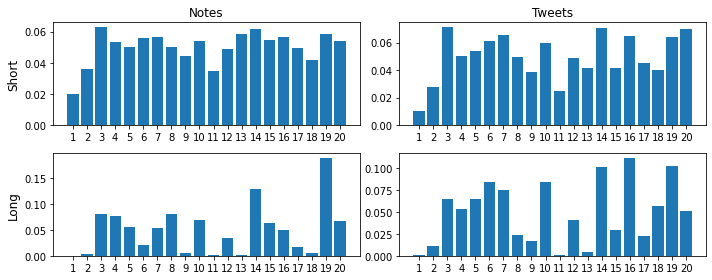

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(10,4))

classes, p, q  = probPlot(santa, "short doc")
axs[0, 0].bar(classes, p )
axs[0, 0].set_title('Notes')
axs[0, 0].set_ylabel("Short", size='large')
axs[0, 1].bar(classes, q )
axs[0, 1].set_title('Tweets')

classes, p, q  = probPlot(mlk, "long doc")

axs[1, 0].bar(classes, p )
axs[1, 0].set_ylabel("Long", size='large')
axs[1, 1].bar(classes, q )

fig.tight_layout()

Does the "short":"uniform topic distribution", "long":"peaky topic distribution" relationship hold for all the data? We can perform a KL test of each distribution against the uniform distribution. 

In [92]:
def KLUniform(test, doc="note"):
    """
    Apply function for a dataframe. Use in a lambda function 
    Input: Distribution dataframe, document type to use
    Output: the relative entropy (KL divergence) KL(P || Q) where P is the document
    topic probability distribution and Q is the uniform distribution
    """
    uniform_distr = np.empty(20)
    uniform_distr.fill(1/20)
    if doc == "tweet":
        X = literal_eval(test['probs_tweet'])
    elif doc == "note":
        X = literal_eval(test['probs_note'])
    X = np.array(list(X.values()))
    # the rel_entr function yields an element-wise divergence, and must be summed
    return sum(rel_entr(X,uniform_distr))

def KSTwo(test):
    """
    Apply function for a dataframe. Use in a lambda function 
    Input: Distribution dataframe, document type to use
    Output: the relative entropy (KL divergence) KL(P || Q) where P is the document
    topic probability distribution and Q is the uniform distribution
    """
    X = literal_eval(test['probs_tweet'])
    Y  = literal_eval(test['probs_note'])
    X = np.array(list(X.values()))
    Y = np.array(list(Y.values()))
    return stats.kstest(X, Y)[0]


In [93]:
# Apply the KL test against the uniform distribution
merged_df['KL_Note'] = merged_df.apply(lambda x: KLUniform(x, "note"), axis = 1 )
merged_df['KL_Tweet'] = merged_df.apply(lambda x: KLUniform(x, "tweet"), axis = 1 )

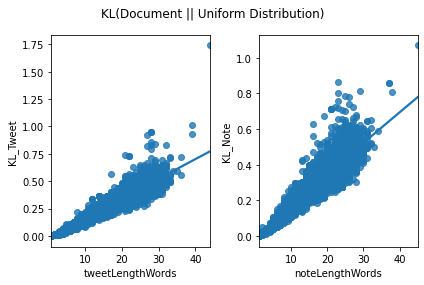

In [94]:
# The plot below gives us a good indicator that the longer the doc
# the less similar (or the more divergent) it is to the uniform distribution

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('KL(Document || Uniform Distribution)')
sns.regplot(ax=ax1, data=merged_df, y="KL_Tweet", x="tweetLengthWords", lowess=True)
sns.regplot(ax=ax2, data=merged_df, y="KL_Note", x="noteLengthWords", lowess=True)
fig.tight_layout()
plt.savefig("KLUniform.png")

In [95]:
# Applying KL test to notes and tweets, to test how similar they are 

test['KL_nt'] = test.apply(lambda x: KL(x, "nt"), axis=1)
test['KL_tn'] = test.apply(lambda x: KL(x, "tn"), axis=1)

test['KS'] = test.apply(lambda x: KSTwo(x), axis=1)

<ipython-input-95-c4636ca74af9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['KL_nt'] = test.apply(lambda x: KL(x, "nt"), axis=1)
<ipython-input-95-c4636ca74af9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['KL_tn'] = test.apply(lambda x: KL(x, "tn"), axis=1)
<ipython-input-95-c4636ca74af9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [96]:
def OLS_Test(regressand, note_length_limit=0, tweet_length_limit=0):
    lm = smf.ols('helpfulnessLevel_proxy ~ {}'.format(regressand),
                 test[
                     (test['tweetLengthWords'] >= tweet_length_limit ) & 
                     (test['noteLengthWords'] >= note_length_limit )
                    ]
                )
    result = lm.fit(cov_type = 'HC0')
    print(regressand)
    return[ np.round(result.pvalues[1],5),
          [np.round(x,5) for x in result.conf_int().iloc[1].tolist()], 
          np.round(result.params[1],3), np.round(result.bse[1],3)]

In [97]:
results = []
print ("no length limits ")

x = OLS_Test("KL_nt")
results.append(["KL_nt",0,0]+x)

y = OLS_Test("KL_tn")
results.append(["KL_tn",0,0]+y)

print ("limiting all documents by 8 ")
w = OLS_Test("KL_nt", 8, 8) # min length of 8 chosen because it is the first quartile of doc length
results.append(["KL_nt",8,8]+w)

v = OLS_Test("KL_tn", 8, 8) 
results.append(["KL_tn",8,8]+v)

print ("limiting only tweets by 8 ")
a = OLS_Test("KL_nt", 0, 8) # min length of 8 chosen because it is the first quartile of doc length
results.append(["KL_nt",0,8]+a)

b = OLS_Test("KL_tn", 0, 8) 
results.append(["KL_tn",0,8]+b)

print ("limiting only notes by 8 ")
g = OLS_Test("KL_nt", 8, 0) # min length of 8 chosen because it is the first quartile of doc length
results.append(["KL_nt",8,0]+g)

h = OLS_Test("KL_tn", 8, 0) 
results.append(["KL_tn ",8,0]+h)

no length limits 
KL_nt
KL_tn
limiting all documents by 8 
KL_nt
KL_tn
limiting only tweets by 8 
KL_nt
KL_tn
limiting only notes by 8 
KL_nt
KL_tn


In [100]:
out = pd.DataFrame(results)
out.columns = ["Regressor", "Note Min", "Tweet Min", "P Val", "Confidence Int", "Coef", "Std Error"]

In [104]:
out

,Regressor,Note Min,Tweet Min,P Val,Confidence Int,Coef,Std Error
0,KL_nt,0,0,0.00000,"[-0.39123, -0.19076]",-0.291,0.051
1,KL_tn,0,0,0.34810,"[-0.15297, 0.05393]",-0.050,0.053
2,KL_nt,8,8,0.59995,"[-0.24232, 0.14001]",-0.051,0.098
3,KL_tn,8,8,0.58705,"[-0.14735, 0.26032]",0.056,0.104
4,KL_nt,0,8,0.00000,"[-0.48458, -0.26974]",-0.377,0.055
5,KL_tn,0,8,0.00045,"[-0.45594, -0.12929]",-0.293,0.083
6,KL_nt,8,0,0.49144,"[-0.21702, 0.10424]",-0.056,0.082
7,KL_tn,8,0,0.92159,"[-0.10722, 0.11856]",0.006,0.058


In [103]:
out_latex = out[['Regressor', 'Note Min', 'Tweet Min', 'Coef']]
print(out_latex.to_latex(index=False, caption="Regression Results with Document Length Limits"))

\begin{table}
\centering
\caption{Regression Results with Document Length Limits}
\begin{tabular}{lrrr}
\toprule
Regressor &  Note Min &  Tweet Min &   Coef \\
\midrule
    KL\_nt &         0 &          0 & -0.291 \\
    KL\_tn &         0 &          0 & -0.050 \\
    KL\_nt &         8 &          8 & -0.051 \\
    KL\_tn &         8 &          8 &  0.056 \\
    KL\_nt &         0 &          8 & -0.377 \\
    KL\_tn &         0 &          8 & -0.293 \\
    KL\_nt &         8 &          0 & -0.056 \\
   KL\_tn  &         8 &          0 &  0.006 \\
\bottomrule
\end{tabular}
\end{table}



In [15]:
out.to_csv("regression_results.csv")

In [16]:
out

,Regressand,Note Min,Tweet Min,P Val,Confidence Int,Coef,Std Error
0,KL_nt,0,0,0.00000,"[-0.39123, -0.19076]",-0.291,0.051
1,KL_tn,0,0,0.34810,"[-0.15297, 0.05393]",-0.050,0.053
2,KL_nt,8,8,0.59995,"[-0.24232, 0.14001]",-0.051,0.098
3,KL_tn,8,8,0.58705,"[-0.14735, 0.26032]",0.056,0.104
4,KL_nt,0,8,0.00000,"[-0.48458, -0.26974]",-0.377,0.055
5,KL_tn,0,8,0.00045,"[-0.45594, -0.12929]",-0.293,0.083
6,KL_nt,8,0,0.49144,"[-0.21702, 0.10424]",-0.056,0.082
7,KL_tn,8,0,0.92159,"[-0.10722, 0.11856]",0.006,0.058


#### model specification geared towards separately identifying the impact of the KL distance between notes and tweets and the length of both the notes and the tweets on the helpfulness level.

In [17]:
#lm = smf.ols('helpfulnessLevel_proxy ~ KS + tweetLengthWords + noteLengthWords', test[(test['tweetLengthWords'] > 9) | (test['noteLengthWords'] > 9)])
lm = smf.ols('helpfulnessLevel_proxy ~ KL_nt + KL_nt * noteLengthWords + KL_nt * tweetLengthWords + tweetLengthWords + noteLengthWords', test)

result = lm.fit(cov_type = 'HC0')

In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     helpfulnessLevel_proxy   R-squared:                       0.016
Model:                                OLS   Adj. R-squared:                  0.015
Method:                     Least Squares   F-statistic:                     27.57
Date:                    Sat, 26 Feb 2022   Prob (F-statistic):           8.80e-28
Time:                            11:06:47   Log-Likelihood:                -7587.6
No. Observations:                    8427   AIC:                         1.519e+04
Df Residuals:                        8421   BIC:                         1.523e+04
Df Model:                               5                                         
Covariance Type:                      HC0                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2830      0.026     10.826      0.000       0.232       0.334
KL_nt                     -0.4743      0.209     -2.270      0.023      -0.884      -0.065
noteLengthWords            0.0081      0.002      5.381      0.000       0.005       0.011
KL_nt:noteLengthWords      0.0086      0.008      1.086      0.278      -0.007       0.024
tweetLengthWords          -0.0031      0.001     -2.178      0.029      -0.006      -0.000
KL_nt:tweetLengthWords     0.0093      0.008      1.164      0.244      -0.006       0.025
==============================================================================
Omnibus:                      693.472   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              724.851
Skew:                          -0.673   Prob(JB):                    3.99e-158
Kurtosis:                       2.497   Cond. No.                         660.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

#### RQ 2 

In [37]:
# assuming these refer to the same "added important context" checkbox in the UI; or that "helpfulUniqueContext"
# is a deprecated version of the same thing 
context_add = test[(test['helpfulUniqueContext'] > 0) | (test['helpfulImportantContext'] > 0)]

#also adding in a column to test to ID notes with adfded context 
test["add_context"] = np.where(((test['helpfulUniqueContext'] > 0) | (test['helpfulImportantContext'] > 0)), 1, 0)

<ipython-input-37-eaf9634b1296>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["add_context"] = np.where(((test['helpfulUniqueContext'] > 0) | (test['helpfulImportantContext'] > 0)), 1, 0)


In [38]:
context_add.shape

(5832, 18)

In [21]:
off_topic = test[test["notHelpfulOffTopic"] > 0]

In [22]:
context_add.helpfulnessLevel_proxy.describe()

count    5832.000000
mean        0.424756
std         0.514128
min        -0.972603
25%         0.000000
50%         0.500000
75%         0.900000
max         1.000000
Name: helpfulnessLevel_proxy, dtype: float64

In [23]:
high_context_add = test[test['noteId'] == 1401836477294821376]

In [24]:
highly_off_topic = test[test['noteId'] == 1407889858874458115]

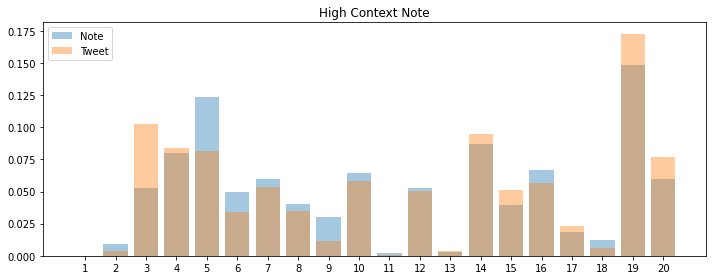

In [105]:
fig, axs = plt.subplots(figsize=(10,4))
classes, p , q = probPlot(high_context_add, "high context")
axs.bar(classes, p, label = "Note", alpha  = 0.4)
axs.bar(classes, q , label = "Tweet", alpha  = 0.4)
plt.legend()
plt.title("High Context Note")
fig.tight_layout()
plt.savefig("HighContext.png")

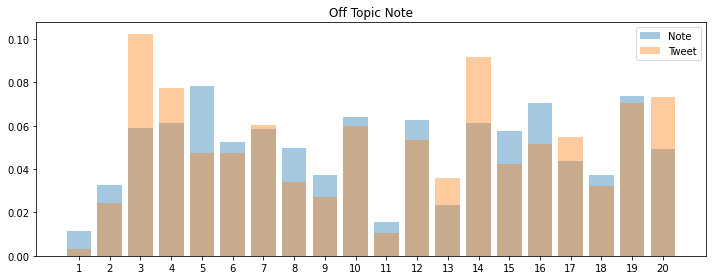

In [26]:
fig, axs = plt.subplots(figsize=(10,4))
classes, p , q = probPlot(highly_off_topic, "off topic")
axs.bar(classes, p, label = "Note", alpha  = 0.4)
axs.bar(classes, q , label = "Tweet", alpha  = 0.4)
plt.legend()
plt.title("Off Topic Note")
fig.tight_layout()

In [27]:
lm = smf.ols('helpfulnessLevel_proxy ~ KL_nt', off_topic)
result = lm.fit(cov_type = 'HC0')
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     helpfulnessLevel_proxy   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     5.608
Date:                    Sat, 26 Feb 2022   Prob (F-statistic):             0.0183
Time:                            11:06:52   Log-Likelihood:                -58.282
No. Observations:                     471   AIC:                             120.6
Df Residuals:                         469   BIC:                             128.9
Df Model:                               1                                         
Covariance Type:                      HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [28]:
lm = smf.ols('helpfulnessLevel_proxy ~ KL_nt', context_add)
result = lm.fit(cov_type = 'HC0')
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     helpfulnessLevel_proxy   R-squared:                       0.003
Model:                                OLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     15.91
Date:                    Sat, 26 Feb 2022   Prob (F-statistic):           6.72e-05
Time:                            11:06:52   Log-Likelihood:                -4387.0
No. Observations:                    5832   AIC:                             8778.
Df Residuals:                        5830   BIC:                             8791.
Df Model:                               1                                         
Covariance Type:                      HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [ ]:
lm = smf.ols('helpfulnessLevel_proxy ~ KL_nt + KL_nt * noteLengthWords + KL_nt * tweetLengthWords + tweetLengthWords + noteLengthWords', test)

result = lm.fit(cov_type = 'HC0')

In [29]:
context_add.describe()

,Unnamed: 0,noteId,tweetId,tweetLengthWords,noteLengthWords,helpfulnessLevel_proxy,helpfulUniqueContext,helpfulImportantContext,notHelpfulOffTopic,KL_nt,KL_tn,KS
count,5832.000000,5.832000e+03,5.832000e+03,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000
mean,5776.694616,1.434926e+18,1.429715e+18,14.953018,15.480624,0.424756,0.483882,5.216049,0.079904,0.134097,0.136600,0.224005
std,3334.372472,3.471298e+16,6.765999e+16,7.847032,7.283911,0.514128,1.559239,10.243291,0.613232,0.123599,0.126214,0.085568
min,1.000000,1.352797e+18,1.305232e+10,1.000000,1.000000,-0.972603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2890.750000,1.415162e+18,1.412856e+18,8.000000,10.000000,0.000000,0.000000,1.000000,0.000000,0.052070,0.052444,0.150000
50%,5780.500000,1.440560e+18,1.439908e+18,14.000000,16.000000,0.500000,0.000000,2.000000,0.000000,0.097349,0.098639,0.200000
75%,8637.000000,1.461791e+18,1.460964e+18,22.000000,22.000000,0.900000,0.000000,5.000000,0.000000,0.175318,0.176194,0.250000
max,11598.000000,1.487868e+18,1.487754e+18,39.000000,45.000000,1.000000,31.000000,147.000000,20.000000,1.188956,1.140790,0.650000


In [30]:
test[(test['helpfulUniqueContext'] == 0) & (test['helpfulImportantContext'] == 0)].describe()

,Unnamed: 0,noteId,tweetId,tweetLengthWords,noteLengthWords,helpfulnessLevel_proxy,helpfulUniqueContext,helpfulImportantContext,notHelpfulOffTopic,KL_nt,KL_tn,KS
count,2595.000000,2.595000e+03,2.595000e+03,2595.000000,2595.000000,2595.000000,2595.0,2595.0,2595.000000,2595.000000,2595.000000,2595.000000
mean,5901.473988,1.408116e+18,1.405081e+18,14.670906,13.539884,0.116989,0.0,0.0,0.139114,0.137868,0.130857,0.228574
std,3392.208122,4.018558e+16,4.759978e+16,7.892125,7.574880,0.714467,0.0,0.0,0.530772,0.134816,0.120868,0.087629
min,8.000000,1.354600e+18,7.959991e+17,1.000000,1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,3023.500000,1.372150e+18,1.370182e+18,8.000000,7.000000,-0.500000,0.0,0.0,0.000000,0.049093,0.047681,0.150000
50%,5936.000000,1.402068e+18,1.399872e+18,14.000000,13.000000,0.111111,0.0,0.0,0.000000,0.095416,0.095774,0.200000
75%,8903.500000,1.442899e+18,1.441789e+18,22.000000,20.000000,0.800000,0.0,0.0,0.000000,0.179568,0.175790,0.300000
max,11596.000000,1.487791e+18,1.487637e+18,35.000000,34.000000,1.000000,0.0,0.0,9.000000,1.230621,1.434532,0.650000


In [31]:
off_topic.describe()

,Unnamed: 0,noteId,tweetId,tweetLengthWords,noteLengthWords,helpfulnessLevel_proxy,helpfulUniqueContext,helpfulImportantContext,notHelpfulOffTopic,KL_nt,KL_tn,KS
count,471.000000,4.710000e+02,4.710000e+02,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000
mean,5618.804671,1.381682e+18,1.376969e+18,14.997877,14.078556,0.356636,1.488323,0.165605,1.755839,0.142487,0.136490,0.233227
std,3406.448995,1.929466e+16,5.513126e+16,8.339218,7.736360,0.275147,2.794252,0.914520,1.821223,0.143116,0.120154,0.088215
min,4.000000,1.354600e+18,6.420987e+17,1.000000,1.000000,-0.377358,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2819.500000,1.362500e+18,1.362099e+18,7.000000,7.000000,0.125000,0.000000,0.000000,1.000000,0.050929,0.052691,0.150000
50%,5354.000000,1.380204e+18,1.378470e+18,15.000000,14.000000,0.333333,0.000000,0.000000,1.000000,0.100286,0.102785,0.200000
75%,8566.500000,1.403104e+18,1.403077e+18,23.000000,21.000000,0.571429,2.000000,0.000000,2.000000,0.184703,0.178322,0.300000
max,11586.000000,1.410214e+18,1.410025e+18,31.000000,31.000000,0.947368,21.000000,11.000000,20.000000,1.052215,0.778693,0.650000


In [32]:
test[test["notHelpfulOffTopic"] == 0].describe()

,Unnamed: 0,noteId,tweetId,tweetLengthWords,noteLengthWords,helpfulnessLevel_proxy,helpfulUniqueContext,helpfulImportantContext,notHelpfulOffTopic,KL_nt,KL_tn,KS
count,7956.000000,7.956000e+03,7.956000e+03,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.0,7956.000000,7956.000000,7956.000000
mean,5826.740950,1.429334e+18,1.424803e+18,14.858346,14.930618,0.328405,0.266591,3.813725,0.0,0.134831,0.134734,0.224950
std,3349.222444,3.772524e+16,6.264111e+16,7.832850,7.407657,0.614062,1.135871,9.069658,0.0,0.126152,0.124879,0.086093
min,1.000000,1.352797e+18,1.305232e+10,1.000000,1.000000,-1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2939.750000,1.404480e+18,1.400814e+18,8.000000,9.000000,0.000000,0.000000,0.000000,0.0,0.051024,0.050995,0.150000
50%,5843.500000,1.436850e+18,1.435699e+18,14.000000,15.000000,0.500000,0.000000,1.000000,0.0,0.096321,0.097529,0.200000
75%,8743.250000,1.459098e+18,1.458184e+18,22.000000,21.000000,0.944444,0.000000,3.000000,0.0,0.176379,0.175945,0.250000
max,11598.000000,1.487868e+18,1.487754e+18,39.000000,45.000000,1.000000,31.000000,147.000000,0.0,1.230621,1.434532,0.650000


In [33]:
# t-test between the subset of notes with no context add ratings and those with 
stats.ttest_ind(
    test[(test['helpfulUniqueContext'] == 0) & (test['helpfulImportantContext'] == 0)]['noteLengthWords'], 
    context_add['noteLengthWords'], equal_var = False
)





Ttest_indResult(statistic=-10.98576527930848, pvalue=9.544472560145584e-28)

In [34]:
# noteLengthWords is signifcantly larger for the high context words 

In [35]:
stats.ttest_ind(test[test["notHelpfulOffTopic"] == 0]['noteLengthWords'],
    off_topic['noteLengthWords'], 
     equal_var = False
)



Ttest_indResult(statistic=2.3279182839287205, pvalue=0.02029744665773048)

In [46]:
# Shane's first suggestion: seeing if KL + context add results in higher helpfulness 

lm = smf.ols('helpfulnessLevel_proxy ~ KL_nt + add_context + add_context * KL_nt', test)

result = lm.fit(cov_type = 'HC0')

In [47]:
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     helpfulnessLevel_proxy   R-squared:                       0.060
Model:                                OLS   Adj. R-squared:                  0.059
Method:                     Least Squares   F-statistic:                     142.8
Date:                    Sat, 26 Feb 2022   Prob (F-statistic):           3.02e-90
Time:                            16:20:41   Log-Likelihood:                -7395.5
No. Observations:                    8427   AIC:                         1.480e+04
Df Residuals:                        8423   BIC:                         1.483e+04
Df Model:                               3                                         
Covariance Type:                      HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [49]:
-0.3912 + 0.69206 * 0.1765

-0.26905141

In [48]:
test.describe()

,Unnamed: 0,noteId,tweetId,tweetLengthWords,noteLengthWords,helpfulnessLevel_proxy,helpfulUniqueContext,helpfulImportantContext,notHelpfulOffTopic,KL_nt,KL_tn,KS,add_context
count,8427.000000,8.427000e+03,8.427000e+03,8427.000000,8427.000000,8427.000000,8427.000000,8427.000000,8427.000000,8427.000000,8427.000000,8427.000000,8427.000000
mean,5815.119022,1.426670e+18,1.422129e+18,14.866145,14.882995,0.329983,0.334876,3.609826,0.098137,0.135258,0.134832,0.225412,0.692061
std,3352.582018,3.852583e+16,6.320489e+16,7.861556,7.428516,0.600216,1.316197,8.854918,0.589673,0.127162,0.124613,0.086229,0.461668
min,1.000000,1.352797e+18,1.305232e+10,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2931.500000,1.395149e+18,1.392574e+18,8.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.051018,0.051125,0.150000,0.000000
50%,5815.000000,1.434158e+18,1.433208e+18,14.000000,15.000000,0.457143,0.000000,1.000000,0.000000,0.096558,0.097784,0.200000,1.000000
75%,8736.000000,1.457494e+18,1.456645e+18,22.000000,21.000000,0.888889,0.000000,3.000000,0.000000,0.176633,0.175960,0.250000,1.000000
max,11598.000000,1.487868e+18,1.487754e+18,39.000000,45.000000,1.000000,31.000000,147.000000,20.000000,1.230621,1.434532,0.650000,1.000000


In [43]:
# Shane's second suggestion

lm = smf.ols('add_context ~ KL_nt', test)

result = lm.fit(cov_type = 'HC0')

In [45]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            add_context   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.489
Date:                Sat, 26 Feb 2022   Prob (F-statistic):              0.222
Time:                        15:55:35   Log-Likelihood:                -5442.8
No. Observations:                8427   AIC:                         1.089e+04
Df Residuals:                    8425   BIC:                         1.090e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6988      0.007     94.122      0.0

In [50]:
### appendix

npmi_scores = pd.read_csv("../results/npmi_eval.csv")

In [54]:
npmi_scores.head()

,Unnamed: 0,NClusters,NDims,NPMI_Score,Silhouette_Index,Mean_Cluster_L22
0,0,20,100,-0.648504,0.039281,987.147981
1,1,20,300,-0.673515,0.058287,1454.168769
2,2,20,500,-0.659714,0.053885,1440.699733
3,3,20,768,-0.624713,0.057895,1545.249112
4,4,50,100,-0.776708,0.038466,2883.782986


In [58]:
df = npmi_scores[['NClusters', 'NDims','NPMI_Score','Silhouette_Index']].round(2)

In [60]:
print(df.to_latex(index=False, caption="Evaluation Scores (averaged over three random seeds)"))

\begin{table}
\centering
\caption{Evaluation Scores (averaged over three random seeds)}
\begin{tabular}{rrrr}
\toprule
 NClusters &  NDims &  NPMI\_Score &  Silhouette\_Index \\
\midrule
        20 &    100 &       -0.65 &              0.04 \\
        20 &    300 &       -0.67 &              0.06 \\
        20 &    500 &       -0.66 &              0.05 \\
        20 &    768 &       -0.62 &              0.06 \\
        50 &    100 &       -0.78 &              0.04 \\
        50 &    300 &       -0.73 &              0.05 \\
        50 &    500 &       -0.73 &              0.05 \\
        50 &    768 &       -0.72 &              0.05 \\
       100 &    100 &       -0.81 &              0.04 \\
       100 &    300 &       -0.76 &              0.04 \\
       100 &    500 &       -0.75 &              0.04 \\
       100 &    768 &       -0.73 &              0.04 \\
\bottomrule
\end{tabular}
\end{table}



In [111]:
putin_dict = {('biden', 'putin'): 0.1624897135151736, ('biden', 'russia'): 0.05280760597082321, ('biden', 'usa'): 0.029212901237271893, ('putin', 'biden'): 0.1624897135151736, ('putin', 'russia'): 0.2934069126649716, ('putin', 'usa'): -1.0, ('russia', 'biden'): 0.05280760597082321, ('russia', 'putin'): 0.2934069126649716, ('russia', 'usa'): 0.12406757619409857, ('usa', 'biden'): 0.008004453070156155, ('usa', 'putin'): -1.0, ('usa', 'russia'): 0.12406757619409857}

In [112]:
df = pd.DataFrame([k + (v,) for k, v in putin_dict.items()], columns=['w1', 'w2', 'NPMI'])


In [113]:
df = df.drop_duplicates(subset='NPMI', keep="first")

In [114]:
print(df.round(2).to_latex(index=False, caption="NPMI scores to illustrate missing co-occurences"))

\begin{table}
\centering
\caption{NPMI scores to illustrate missing co-occurences}
\begin{tabular}{llr}
\toprule
    w1 &     w2 &  NPMI \\
\midrule
 biden &  putin &  0.16 \\
 biden & russia &  0.05 \\
 biden &    usa &  0.03 \\
 putin & russia &  0.29 \\
 putin &    usa & -1.00 \\
russia &    usa &  0.12 \\
   usa &  biden &  0.01 \\
\bottomrule
\end{tabular}
\end{table}



In [119]:
df.round(2).NPMI.mode().round(2)

0   -1.00
1    0.01
2    0.03
3    0.05
4    0.12
5    0.16
6    0.29
dtype: float64